In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer

# Informe Técnico de Minería de Datos: Análisis del Clima en Australia

Este notebook se organiza en base a las dos primeras fases de la metodología CRISP-DM: **Business Understanding** y **Data Understanding**. Además, se introduce la idea de construir un “Índice de Riesgo Climático por ciudad” que responda a la pregunta: “¿Qué regiones de Australia tienen más riesgo de fenómenos extremos?” mediante un score que combine:

- **Velocidad de Ráfaga (WindGustSpeed)**
- **Máxima Temperatura (MaxTemp)**
- **Baja Humedad**
- **Alta Precipitación (Rainfall)**

El índice se escalara y presentará por ubicación, generando un ranking de ciudades “más extremas climáticamente” y, para una temporada o fecha específica, se indicarán cuáles son las ciudades con mayor riesgo y qué factores son los determinantes.

---

## 1. Business Understanding

### 1.1. Introducción

El objetivo de este análisis es sentar las bases para el desarrollo de modelos predictivos y la construcción de un índice de riesgo climático. Este índice ayudará a identificar las regiones de Australia con mayor riesgo de fenómenos extremos, lo que es fundamental para la toma de decisiones estratégicas en áreas como la agricultura, el turismo y la gestión de riesgos.

### 1.2. Objetivos del Negocio y KPIs

- **Objetivos del Negocio:**
  - Mejorar la capacidad predictiva del clima mediante modelos que anticipen condiciones adversas.
  - Optimizar recursos y planificaciones basadas en condiciones climáticas específicas.
  - Reducir riesgos al identificar regiones vulnerables a fenómenos extremos.

- **KPIs Relevantes:**
  - Número de días con precipitaciones intensas.
  - Promedio y variabilidad de temperaturas (MinTemp y MaxTemp).
  - Frecuencia de eventos extremos (outliers en Rainfall y RISK_MM).
  - Índices de humedad y presión que ayuden a identificar cambios bruscos en el clima.

## 2. Data Understanding

### 2.1. Carga y Visualización de Datos

In [2]:
df = pd.read_csv('weatherAUS.csv')

In [3]:
print("Primeras filas del dataset:")
print(df.head())

Primeras filas del dataset:
         Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity3pm  Pressure9am  \
0           W           44.0          W  ...        22.0       1007.7   
1         WNW           44.0        NNW  ...        25.0       1010.6   
2         WSW           46.0          W  ...        30.0       1007.6   
3          NE           24.0         SE  ...        16.0       1017.6   
4           W           41.0        ENE  ...        33.0       1010.8   

   Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RISK_

Al analizar las primeras filas del dataset mediante `df.head()` nos permitio tener visión general de la estructura y contenido de los datos climáticos recopilados. A continuación, realizamos algunas algunas observaciones:

- El dataset está compuesto por 24 columnas, que incluyen variables de tipo fecha (`Date`), categóricas como `Location`, `WindGustDir`, `WindDir9am`, `WindDir3pm`, y múltiples columnas numéricas relacionadas con fenómenos climáticos (`MinTemp`, `MaxTemp`, `Rainfall`, etc.).

- La variable `RainTomorrow` parece representar una etiqueta binaria o categórica, lo que sugiere que este dataset pudo haber sido utilizado originalmente para tareas de clasificación. Aunque no es nuestro enfoque principal, podría utilizarse más adelante como referencia o comparación.

- La columna `Date` está correctamente formateada y lista para extracción de componentes temporales como estación, mes o año, lo cual es útil para análisis estacionales y comparación entre ciudades o épocas del año.

- La presencia de múltiples columnas horarias (`WindSpeed9am`, `Humidity3pm`, etc.) indica que los registros climáticos están tomados en distintos momentos del día, lo que enriquece el análisis, ya que permite estudiar variaciones diurnas y construir métricas como amplitud térmica o cambios en humedad relativa.

- A nivel estructural, el orden de las columnas es coherente y muestra un diseño de dataset limpio y manejable. No se observan nombres confusos, abreviaturas ambiguas ni columnas inútiles a primera vista.

In [4]:
print("\nEstadísticas descriptivas:")
print(df.describe())


Estadísticas descriptivas:
             MinTemp        MaxTemp       Rainfall   Evaporation  \
count  141556.000000  141871.000000  140787.000000  81350.000000   
mean       12.186400      23.226784       2.349974      5.469824   
std         6.403283       7.117618       8.465173      4.188537   
min        -8.500000      -4.800000       0.000000      0.000000   
25%         7.600000      17.900000       0.000000      2.600000   
50%        12.000000      22.600000       0.000000      4.800000   
75%        16.800000      28.200000       0.800000      7.400000   
max        33.900000      48.100000     371.000000    145.000000   

           Sunshine  WindGustSpeed   WindSpeed9am   WindSpeed3pm  \
count  74377.000000  132923.000000  140845.000000  139563.000000   
mean       7.624853      39.984292      14.001988      18.637576   
std        3.781525      13.588801       8.893337       8.803345   
min        0.000000       6.000000       0.000000       0.000000   
25%        4.900000

El análisis de las estadísticas descriptivas permite tener una visión más precisa de la distribución y comportamiento general de cada variable numérica. Se observa que muchas de las columnas presentan rangos amplios y desviaciones estándar considerables, lo que ya sugiere la presencia de valores extremos o alta variabilidad, especialmente en variables como `Rainfall`, `WindGustSpeed`, `Evaporation` y `RISK_MM`. Por ejemplo, `Rainfall` tiene un promedio de apenas 2.35 mm, pero alcanza un máximo de 371 mm, reflejando eventos de lluvia intensa pero poco frecuentes, coherente con lo visto en los boxplots e histogramas. 

También se nota que variables como `Sunshine` y `Cloud9am/Cloud3pm` tienen muchos menos datos (`count` significativamente menor), lo cual podría afectar su uso en algunos modelos si no se realiza imputación o análisis específico sobre valores faltantes. Por otro lado, variables como MinTemp, `MaxTemp`, `Humidity`, `Temp9am` y `Temp3pm` presentan promedios bien centrados dentro de sus respectivos rangos y distribuciones más esperadas, lo que las hace ideales como base del análisis climático.

Finalmente, la información de los percentiles (`25%`, `50%`, `75%`) ayuda a comprender la concentración de los datos y posibles puntos de corte para clasificación o categorización futura. Esta descripción estadística es una herramienta fundamental para priorizar qué variables pueden aportar más al Índice de Riesgo Climático, cuáles pueden requerir transformaciones, y qué casos deben ser tratados con mayor atención por su dispersión, falta de datos o posibles valores anómalos.


In [7]:
# Valores faltantes por columna
print("\nValores perdidos por columna:")
print(df.isnull().sum())

# Verificar registros duplicados
print("\nFilas duplicadas:")
print(df.duplicated().sum())


Valores perdidos por columna:
Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

Filas duplicadas:
0


### Revisión de valores nulos y duplicados

Durante esta etapa inicial, revisamos si nuestro dataset contenía registros duplicados y datos faltantes. Nos encontramos con que no hay filas duplicadas, lo cual es una buena señal y nos permite seguir adelante sin tener que hacer limpieza en ese aspecto.

Sin embargo, sí identificamos varias columnas con valores nulos, especialmente aquellas relacionadas con evaporación, horas de sol, nubosidad y dirección del viento. Esto nos hace pensar que, más adelante, vamos a tener que tomar decisiones importantes: o imputar esos datos con alguna técnica adecuada, o evaluar si realmente aportan al análisis y podrían ser descartados sin afectar el resultado final.

Este paso fue clave porque nos ayuda a anticipar posibles obstáculos y planificar desde ya cómo mantener la calidad del análisis sin perder información valiosa.


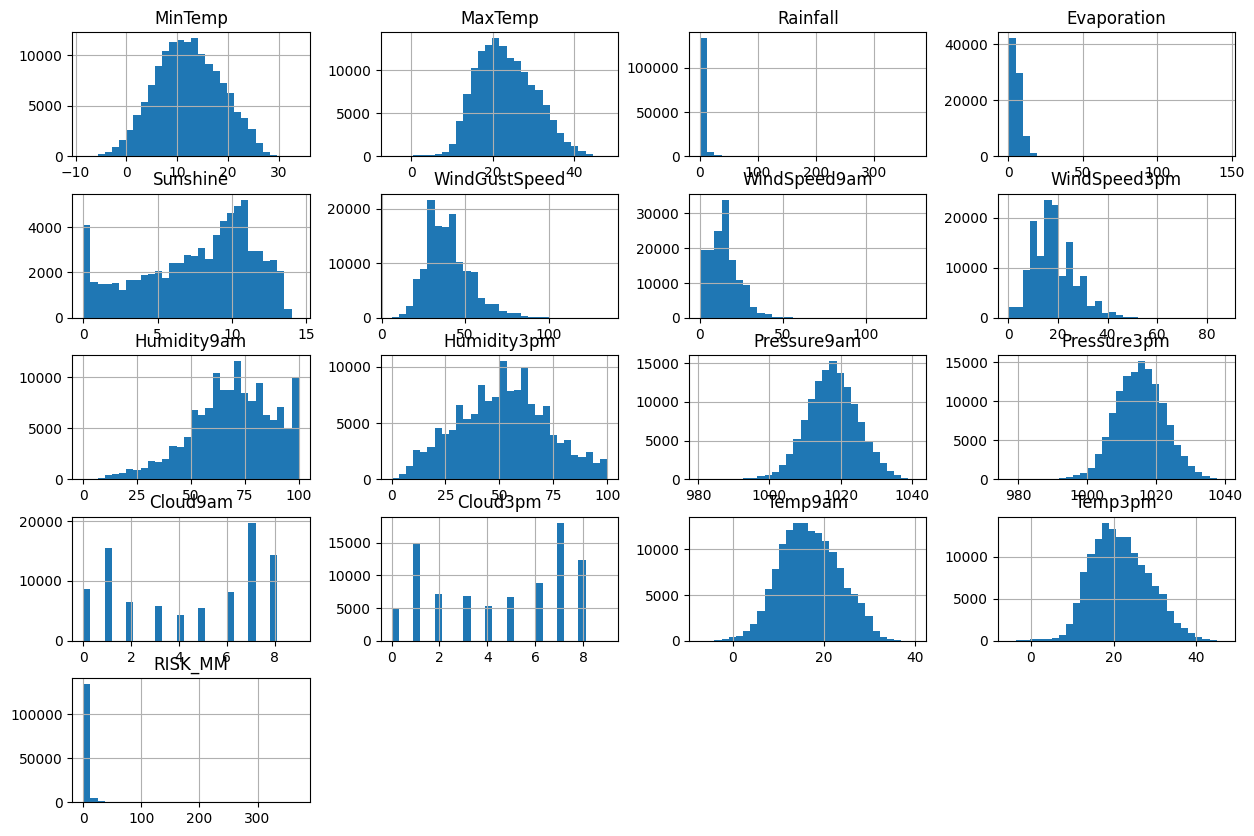

In [8]:
# Histogramas para ver la distribución de variables numéricas
df.hist(bins=30, figsize=(15,10))
plt.show()

### 📊 Observaciones generales sobre los histogramas de variables numéricas

Los histogramas permiten observar la distribución individual de cada variable numérica del dataset. Esta visualización es fundamental para detectar sesgos, formas no normales, concentraciones de datos y posibles transformaciones necesarias antes de aplicar modelos más avanzados.

A partir del análisis global de los gráficos, se pueden identificar algunas tendencias clave:

- Varias variables, como `Rainfall`, `Evaporation` y `WindGustSpeed`, presentan distribuciones asimétricas o con sesgos positivos, donde la mayoría de los datos se agrupan en valores bajos, pero existen casos extremos (colas largas a la derecha). Esto sugiere que podría ser útil aplicar transformaciones (por ejemplo, logarítmica) para normalizar su comportamiento si se desea mejorar el rendimiento de futuros modelos.

- Algunas variables como `MaxTemp`, `MinTemp`, `Pressure9am`, `Temp3pm` y otras, muestran distribuciones aproximadamente normales, lo cual es una buena señal, ya que permite utilizarlas directamente sin necesidad de transformaciones.

- En el caso de `Cloud9am` y `Cloud3pm`, los histogramas reflejan una distribución discreta, probablemente por tratarse de una escala categórica del 0 al 8 (octas de nubosidad). Estas variables deben ser tratadas como ordinales o categóricas si se aplican modelos que lo requieran.

- `RISK_MM` nuevamente destaca por su comportamiento altamente sesgado, con la mayoría de sus valores concentrados en 0, lo que refuerza la necesidad de revisar su significado y evaluar si aporta valor al índice climático o si debe transformarse o tratarse como variable binaria (lluvia sí/no).

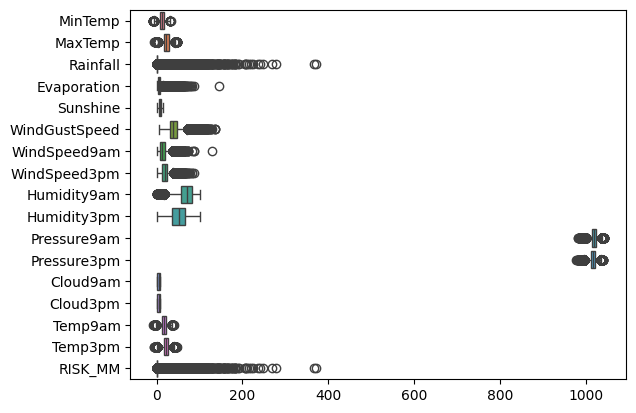

In [9]:
# Boxplot para detectar outliers en variables numéricas
sns.boxplot(data=df.select_dtypes(include=['float64', 'int64']), orient="h")
plt.show()

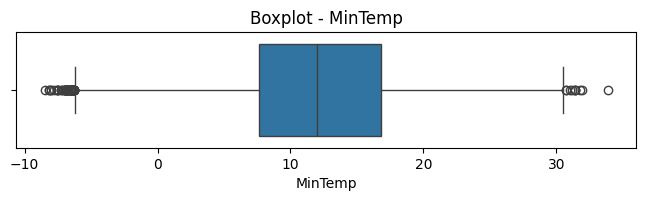

In [8]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["MinTemp"])
plt.title("Boxplot - MinTemp")
plt.show()


### 📊 Boxplot - MinTemp
Esta variable presenta una distribución bastante simétrica con algunos valores atípicos hacia ambos extremos. Podría ser útil para detectar eventos extremos de frío, aunque probablemente sea más significativa si se combina con `Humidity9am` o `Cloud9am` para calcular riesgos de heladas o condiciones frías críticas.

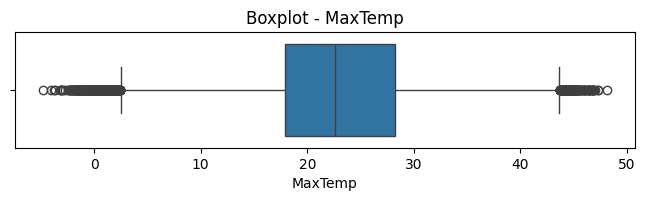

In [9]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["MaxTemp"])
plt.title("Boxplot - MaxTemp")
plt.show()

### 📊 Boxplot - MaxTemp
Se observan outliers hacia temperaturas elevadas, lo que es lógico en climas extremos. Es una de las variables clave para calcular el **riesgo de calor extremo**, por lo que seguramente será utilizada directamente en el índice. Puede ser útil combinarla con `Humidity3pm` o incluso con radiación solar si se incorpora un dataset externo.

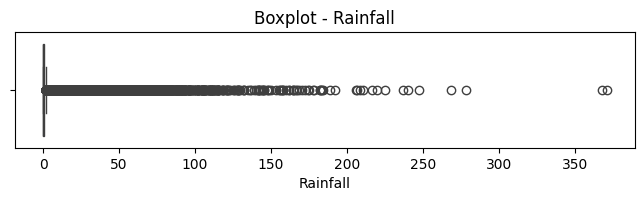

In [10]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Rainfall"])
plt.title("Boxplot - Rainfall")
plt.show()


### 📊 Boxplot - Rainfall
La variable `Rainfall` muestra una distribución muy sesgada con muchos valores cercanos a 0 y varios outliers hacia valores altos. Estos valores extremos podrían representar lluvias intensas o eventos aislados de precipitación fuerte. Es relevante para evaluar riesgo de inundaciones y podría combinarse con `Humidity3pm` para calcular un índice más robusto.

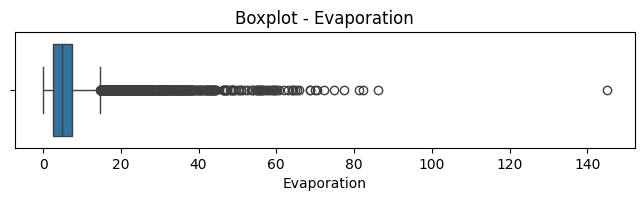

In [26]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Evaporation"])
plt.title("Boxplot - Evaporation")
plt.show()


### 📊 Boxplot - Evaporation
Se observan algunos outliers pero en general la variable parece estar bien distribuida. Podría ser útil para detectar riesgo de **sequía**, especialmente si se combina con humedad baja y baja precipitación. También puede cruzarse con datos externos como índice de vegetación (NDVI).

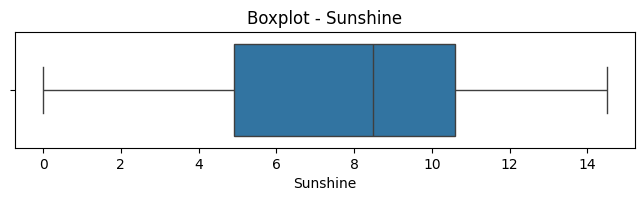

In [12]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Sunshine"])
plt.title("Boxplot - Sunshine")
plt.show()

### 📊 Boxplot - Sunshine
La distribución muestra algunos valores extremos altos, pero es bastante concentrada. Podría no ser crítica por sí sola, pero combinada con alta temperatura y baja humedad puede ayudar a identificar climas áridos o propensos a incendios.

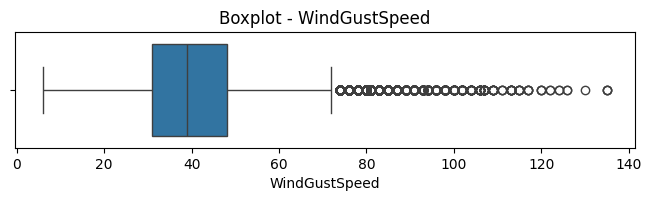

In [13]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["WindGustSpeed"])
plt.title("Boxplot - WindGustSpeed")
plt.show()


### 📊 Boxplot - WindGustSpeed
Presenta outliers muy marcados hacia valores altos, lo cual es consistente con ráfagas de viento extremas. Esta variable es **clave** para detectar **riesgo por viento extremo**, por lo que será útil directamente en nuestro índice. También puede cruzarse con registros de eventos climáticos severos si se consigue un dataset complementario.


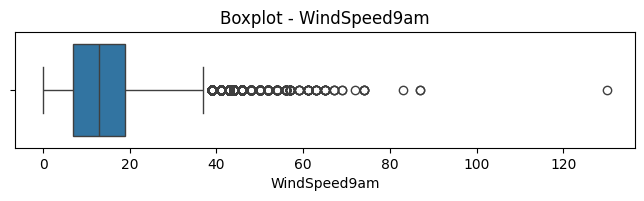

In [14]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["WindSpeed9am"])
plt.title("Boxplot - WindSpeed9am")
plt.show()

### 📊 Boxplot - WindSpeed9am
Tiene distribución relativamente estable, con algunos valores altos. Puede no ser tan crítica por sí sola, pero si se analiza junto con `WindGustSpeed` puede ayudar a determinar variabilidad diaria del viento. Podría descartarse si no mejora el rendimiento del modelo.


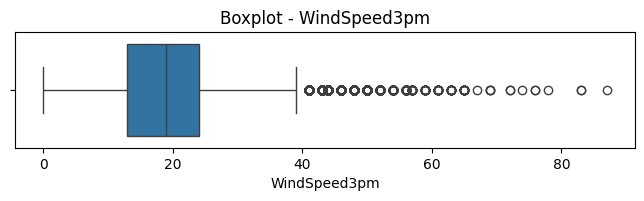

In [15]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["WindSpeed3pm"])
plt.title("Boxplot - WindSpeed3pm")
plt.show()


### 📊 Boxplot - WindSpeed3pm
Similar a `WindSpeed9am`, aunque con ligera mayor dispersión. Si hay que elegir una de las dos, esta podría tener más valor, ya que suele representar condiciones de viento más intensas al final del día. Se puede considerar conservar esta y descartar la otra.

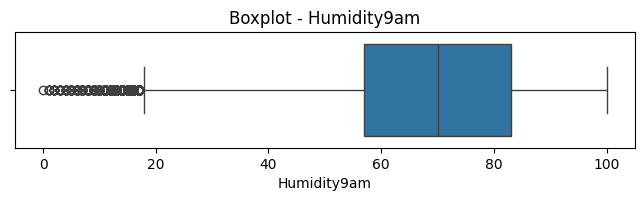

In [16]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Humidity9am"])
plt.title("Boxplot - Humidity9am")
plt.show()

### 📊 Boxplot - Humidity9am
La distribución es bastante normal, aunque con algunos outliers bajos. Por sí sola no indica mucho, pero en combinación con temperatura y nubosidad matinal puede ayudar a estimar sensación térmica o posibles nieblas.


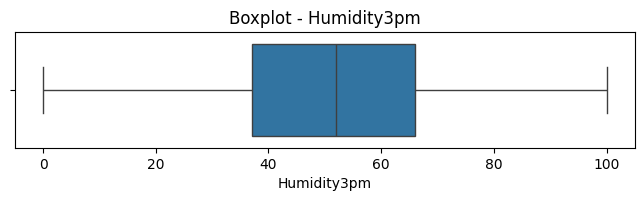

In [17]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Humidity3pm"])
plt.title("Boxplot - Humidity3pm")
plt.show()


### 📊 Boxplot - Humidity3pm
Tiene una distribución más dispersa, con outliers hacia niveles bajos. Esta variable es **muy útil** para identificar sequía o calor extremo, especialmente si se cruza con `MaxTemp`. Sin duda será parte del índice climático.

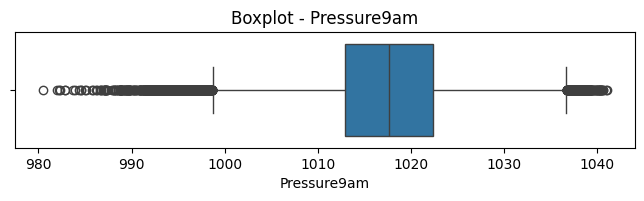

In [18]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Pressure9am"])
plt.title("Boxplot - Pressure9am")
plt.show()

### 📊 Boxplot - Pressure9am
Esta variable tiene valores fuera de lo normal (~1010–1040 hPa) que podrían representar errores de medición o eventos climáticos raros. Podría servir como apoyo, pero no parece clave. Puede descartarse si no se correlaciona con fenómenos extremos.

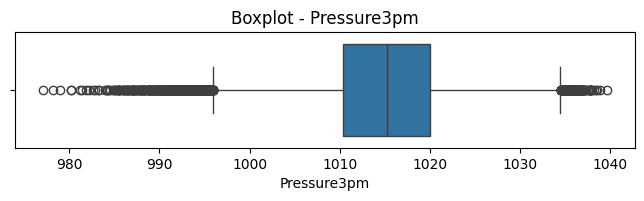

In [19]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Pressure3pm"])
plt.title("Boxplot - Pressure3pm")
plt.show()


### 📊 Boxplot - Pressure3pm
Comportamiento muy similar a `Pressure9am`. Puede analizarse una de las dos para ver si tiene relación con algún fenómeno (por ejemplo, presión baja previa a tormentas), pero en general podría no aportar demasiado.

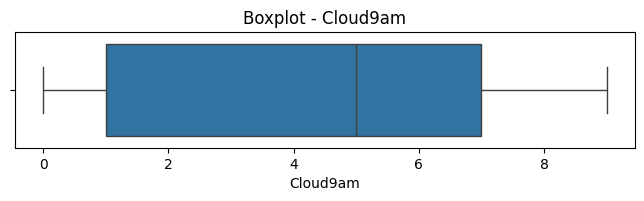

In [20]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Cloud9am"])
plt.title("Boxplot - Cloud9am")
plt.show()

### 📊 Boxplot - Cloud9am
Muy concentrada y con valores enteros. Parece tratarse de una escala categórica del 0 al 8. Puede ayudar a interpretar nubosidad, pero si no se cruza con otra variable (como temperatura o humedad), su utilidad es limitada. Se puede conservar como variable auxiliar.

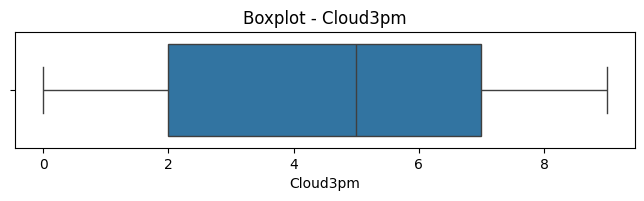

In [21]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Cloud3pm"])
plt.title("Boxplot - Cloud3pm")
plt.show()

### 📊 Boxplot - Cloud3pm
Mismo caso que `Cloud9am`, pero al final del día. Podría tener más valor si se relaciona con `Sunshine` para estimar días despejados. Si hay que elegir, esta podría conservarse.


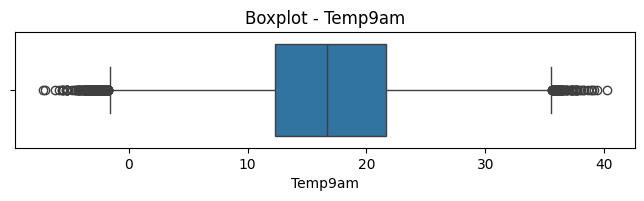

In [22]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Temp9am"])
plt.title("Boxplot - Temp9am")
plt.show()

### 📊 Boxplot - Temp9am
Buena distribución. Puede ser útil para estudiar la evolución térmica diaria si se combina con `MaxTemp` o `Temp3pm`. Puede usarse como variable de apoyo para construir rangos de temperatura diarios.

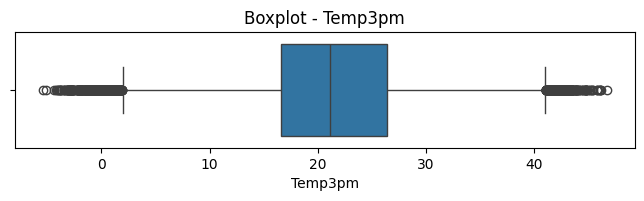

In [23]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Temp3pm"])
plt.title("Boxplot - Temp3pm")
plt.show()


### 📊 Boxplot - Temp3pm
Más alineada con `MaxTemp`, aunque no idéntica. Puede ser útil para verificar patrones de temperatura media diurna. Probablemente no forme parte directa del índice, pero sí en análisis secundarios.

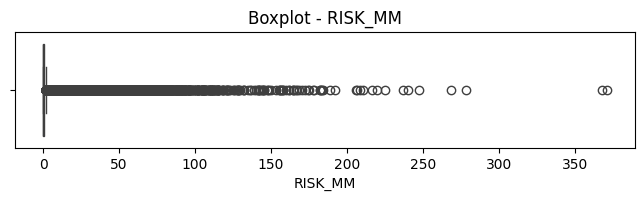

In [24]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["RISK_MM"])
plt.title("Boxplot - RISK_MM")
plt.show()

### 📊 Boxplot - RISK_MM
Aunque no está del todo claro su significado en la descripción original, esta variable parece representar una medida asociada a riesgo (¿quizás probabilidad de lluvia?). Tiene muchos valores bajos y algunos extremos. Debería investigarse más antes de decidir si se incluye o no.

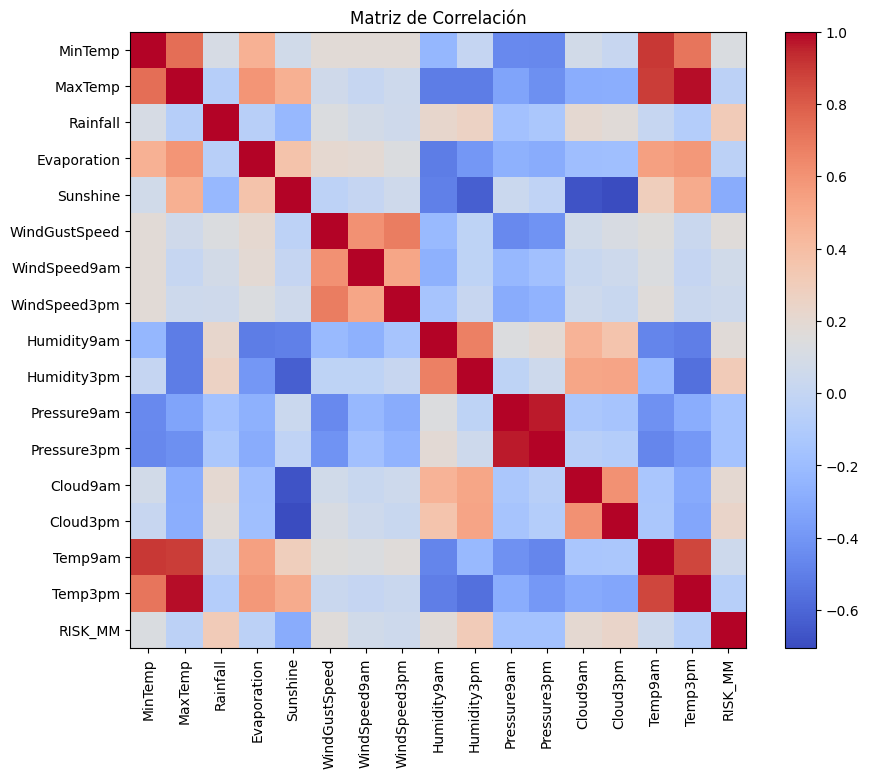

In [10]:
# Seleccionar columnas numéricas y calcular la matriz de correlación
df_numeric = df.select_dtypes(include=[np.number])
corr = df_numeric.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Matriz de Correlación")
plt.show()

### 🔍Observaciones de la Matriz de Correlación

A partir del análisis de la matriz de correlación se pueden destacar diversas relaciones entre las variables numéricas del conjunto de datos. Estas correlaciones permiten identificar posibles redundancias, dependencias o relaciones clave entre fenómenos climáticos. A continuación se presentan algunas conclusiones relevantes:

---

#### Temperatura mínima (MinTemp) y temperatura máxima (MaxTemp)

Existe una **alta correlación positiva** entre ambas variables, lo que es esperable dado que ambas describen el comportamiento térmico diario. Esto indica que cuando la temperatura mínima es alta, la máxima también tiende a serlo. Aunque ambas aportan información, podrían usarse juntas para calcular amplitud térmica diaria, o elegir solo una si es necesario simplificar.

---

#### Temp9am y Temp3pm

Se observa también una **fuerte correlación positiva**, lo que sugiere que podrían ser redundantes. Si se requiere reducir dimensionalidad, se podría conservar solo `Temp3pm` por representar una hora más cálida del día. Sin embargo, su diferencia también podría ser usada para calcular variabilidad térmica.

---

#### WindSpeed9am, WindSpeed3pm y WindGustSpeed

Estas tres variables están moderadamente correlacionadas entre sí, especialmente `WindSpeed3pm` con `WindGustSpeed`. Esto sugiere que los días con vientos fuertes en la tarde también presentan ráfagas considerables. Se podría considerar usar solo `WindGustSpeed` como indicador de condiciones extremas, ya que tiene más relevancia para riesgos.

---

#### Evaporation y Sunshine

Presentan una **correlación positiva media**, lo cual es lógico, ya que mayor exposición solar tiende a generar mayor evaporación. Esta relación respalda que ambas pueden participar en un cálculo para estimar sequía o estrés térmico. Pese a ello, ambas variables aportan matices distintos y pueden usarse conjuntamente si el modelo lo permite.

---

####  Cloud9am y Sunshine

Existe una **correlación negativa fuerte** entre la nubosidad matinal y la cantidad de sol. Es una relación esperada: a mayor nubosidad, menor radiación solar. Esta relación refuerza que una de las dos podría usarse como proxy de la otra si se desea simplificar el modelo.

---

#### Humidity3pm y Evaporation

Existe una **correlación negativa significativa**, lo cual tiene sentido físico: a menor humedad relativa en la tarde, mayor es la capacidad de evaporación. Esta relación puede ser clave para construir indicadores de **sequía o deshidratación del ambiente**, especialmente si se combina con temperatura máxima.

---

#### Rainfall con otras variables

La variable `Rainfall` no muestra correlaciones fuertes con ninguna otra variable del conjunto. Esto sugiere que el nivel de precipitaciones es un fenómeno bastante independiente, y por tanto aporta información única y valiosa para modelar eventos extremos como lluvias intensas o inundaciones.

---

#### RISK_MM

La variable `RISK_MM` presenta algunas correlaciones débiles, pero no destaca por relaciones fuertes con ninguna otra variable. Esto podría significar que representa una medida calculada con lógica propia o que depende de factores externos no incluidos en este dataset. Se recomienda revisar su definición original para decidir su inclusión.

---

### Conclusión general

La matriz de correlación permite visualizar tanto relaciones esperadas como confirmar independencia entre variables. Esto es muy útil para:

- Identificar variables redundantes.
- Combinar adecuadamente factores para construir indicadores.
- Detectar aquellas que aportan información única.

Este análisis servirá como base para seleccionar variables clave en la construcción del **Índice de Riesgo Climático por ciudad**, priorizando aquellas que se relacionan directamente con fenómenos extremos como calor, viento, lluvia intensa o sequía.

# 1. Conclusiones a partir de los resultados

A partir de los histogramas, boxplots, matriz de correlación y estadísticas descriptivas, se pueden extraer varios insights:

1. **Distribución de las variables (Histogramas):**  
   - Algunas variables (por ejemplo, *Rainfall* y *RISK_MM*) presentan distribuciones muy asimétricas, con la mayoría de valores en rangos bajos y unos pocos extremadamente altos.  
   - *MinTemp* y *MaxTemp* parecen más cercanas a distribuciones normales, aunque muestran colas que indican días inusualmente fríos o cálidos.

2. **Outliers identificados (Boxplots):**  
   - Existen valores atípicos en *Rainfall*, *Evaporation* y *RISK_MM*. Podrían corresponder a fenómenos climáticos extremos o a errores de medición.  
   - Estos outliers pueden distorsionar análisis estadísticos, por lo que conviene confirmar su veracidad.

3. **Matriz de Correlación:**  
   - Se aprecia una correlación positiva notable entre *MinTemp* y *MaxTemp*.  
   - Variables como *Sunshine* y *Cloud9am/Cloud3pm* suelen relacionarse de forma inversa, aunque esto se ve limitado por la cantidad de valores faltantes.  
   - Este análisis de correlación es útil para la selección de variables relevantes en futuros modelos o índices.

4. **Valores Faltantes y Duplicados:**  
   - Hay un número significativo de valores nulos en *Evaporation*, *Sunshine*, *Cloud9am* y *Cloud3pm*. Será esencial decidir si se imputan o se descartan.  
   - No hay filas duplicadas, lo que es positivo para la integridad del dataset.

5. **Variabilidad por Ubicación:**  
   - El dataset incluye múltiples ciudades con patrones climáticos distintos. La ubicación es un factor relevante para identificar eventos extremos específicos de cada región.

---

# 2. Profundizar en el Análisis para Cumplir los Objetivos de Negocio

1. **Limpieza y Preparación de Datos (Data Preparation):**  
   - **Imputación de valores faltantes:**  
     - Usar la mediana o la media en variables con distribución no muy sesgada.  
     - Emplear técnicas avanzadas (KNN imputation) cuando existan correlaciones fuertes con otras variables.  
     - Considerar descartar variables si el porcentaje de datos faltantes es muy alto y su impacto en el objetivo de negocio es bajo.
   - **Tratamiento de Outliers:**  
     - Verificar si los valores extremos son reales (días con lluvias torrenciales o vientos muy fuertes) o errores.  
     - Si son reales, pueden ser cruciales para un análisis de riesgo. De lo contrario, es posible corregirlos o eliminarlos.

2. **Análisis de Estacionalidad y Agrupaciones:**  
   - Convertir *Date* a formato datetime para extraer mes, estación o año.  
   - Agrupar por *Location* y por períodos (mensuales, trimestrales) para ver tendencias y estacionalidades en diferentes regiones.

3. **Creación de un Índice de Riesgo Climático:**  
   - Alinear con la pregunta de negocio: “¿Qué regiones de Australia tienen más riesgo de fenómenos extremos?”  
   - Seleccionar variables clave (por ejemplo, *Rainfall*, *MaxTemp*, *WindGustSpeed*, *Humidity*).  
   - Normalizarlas y combinarlas en un score único.  
   - Calcular un ranking por ciudad o por temporada, destacando los factores que contribuyen al riesgo.

4. **Modelado Predictivo (Fases Posteriores):**  
   - Una vez limpios los datos, se pueden entrenar modelos de clasificación o regresión para predecir la ocurrencia de eventos extremos.  
   - Esto ayudaría a la compañía a planificar recursos y mitigar riesgos.

5. **Visualizaciones Avanzadas:**  
   - Mapas geoespaciales (si hay coordenadas disponibles) para ubicar riesgos climáticos en el territorio.  
   - Series de tiempo para mostrar la evolución de variables críticas a lo largo de las estaciones.


# Limpieza de Datos

## 1. Análisis de Valores Faltantes

In [11]:
# Mostrar la cantidad de valores faltantes por columna
print("Valores faltantes por columna:")
print(df.isnull().sum())

Valores faltantes por columna:
Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64


## 2. Imputación de Valores Faltantes en Variables Numéricas
Para variables numéricas con missing moderados, imputaremos usando la mediana:

In [12]:
# Imputar la mediana para la columna MinTemp y MaxTemp
df['MinTemp'] = df['MinTemp'].fillna(df['MinTemp'].median())
df['MaxTemp'] = df['MaxTemp'].fillna(df['MaxTemp'].median())

# Verificar que se han imputado
print("Valores faltantes después de imputar MinTemp y MaxTemp:")
print(df[['MinTemp', 'MaxTemp']].isnull().sum())

Valores faltantes después de imputar MinTemp y MaxTemp:
MinTemp    0
MaxTemp    0
dtype: int64


## 3. Imputación de Valores Faltantes en Variables Categóricas
Para variables categóricas, podemos imputar usando la moda. Por ejemplo, para RainToday:

In [13]:
# Imputar la moda para la columna RainToday
df['RainToday'] = df['RainToday'].fillna(df['RainToday'].mode()[0])

print("Valores faltantes después de imputar RainToday:")
print(df['RainToday'].isnull().sum())

Valores faltantes después de imputar RainToday:
0


## 4. Conversión de la Columna de Fechas
Es importante convertir la columna Date a formato datetime para facilitar el análisis temporal:

In [14]:
# Convertir la columna Date a datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Verificar el cambio de tipo
print("Tipo de dato de Date después de la conversión:")
print(df['Date'].dtype)

Tipo de dato de Date después de la conversión:
datetime64[ns]


## 5. Detección de Outliers con el Método del IQR
Podemos usar el método del rango intercuartílico (IQR) para identificar outliers:

In [15]:
# Calcular Q1, Q3 e IQR para la variable Rainfall
Q1 = df['Rainfall'].quantile(0.25)
Q3 = df['Rainfall'].quantile(0.75)
IQR = Q3 - Q1

print("Q1 de Rainfall:", Q1)
print("Q3 de Rainfall:", Q3)
print("IQR de Rainfall:", IQR)

# Identificar outliers: valores por debajo de Q1 - 1.5*IQR o por encima de Q3 + 1.5*IQR
outliers = df[(df['Rainfall'] < Q1 - 1.5 * IQR) | (df['Rainfall'] > Q3 + 1.5 * IQR)]
print("Número de outliers en Rainfall:", outliers.shape[0])

Q1 de Rainfall: 0.0
Q3 de Rainfall: 0.8
IQR de Rainfall: 0.8
Número de outliers en Rainfall: 25228


# Aplicación de Técnicas Avanzadas de Imputación con KNNImputer

Para variables como **Sunshine** y **Evaporation** que tienen un alto porcentaje de valores faltantes, podemos aplicar el método de imputación basado en KNN (K-Nearest Neighbors). Este método utiliza la información de los vecinos más cercanos para estimar los valores faltantes.

In [16]:
# Seleccionar las columnas que se imputarán
cols_to_impute = ['Sunshine', 'Evaporation']
print(cols_to_impute)

['Sunshine', 'Evaporation']


In [ ]:
# Crear el objeto KNNImputer, usando 5 vecinos (puedes ajustar n_neighbors según convenga)
imputer = KNNImputer(n_neighbors=5)

# Aplicar la imputación a las columnas seleccionadas
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

# Verificar que ya no hay valores faltantes en estas columnas
print("Valores faltantes en 'Sunshine' y 'Evaporation' después de la imputación:")
print(df[cols_to_impute].isnull().sum())

# Evaluación de la Relevancia de los Outliers

Para determinar si los outliers en la variable *Rainfall* aportan información relevante (por ejemplo, si representan eventos extremos reales como lluvias torrenciales) o si son errores de medición, se pueden realizar varios análisis. A continuación, se presentan comandos y métodos que te ayudarán a investigar:

In [ ]:
# Crear una columna que indique si el valor es outlier
df['Rainfall_Outlier'] = ((df['Rainfall'] < Q1 - 1.5 * IQR) | (df['Rainfall'] > Q3 + 1.5 * IQR)).astype(int)

# Mostrar el conteo total de outliers
print("Número de outliers (con indicador en columna):", df['Rainfall_Outlier'].sum())

In [ ]:
# Crear subconjuntos de datos
outlier_data = df[df['Rainfall_Outlier'] == 1]
non_outlier_data = df[df['Rainfall_Outlier'] == 0]

print("Estadísticas de Rainfall para Outliers:")
print(outlier_data['Rainfall'].describe())

print("\nEstadísticas de Rainfall para No Outliers:")
print(non_outlier_data['Rainfall'].describe())

In [ ]:
# Sumar outliers por ciudad (Location)
outliers_por_ciudad = df.groupby('Location')['Rainfall_Outlier'].sum()
print("Número de outliers por ciudad:")
print(outliers_por_ciudad.sort_values(ascending=False))

In [ ]:
# Extraer el año de la columna Date
df['Year'] = df['Date'].dt.year

# Conteo de outliers por año
outliers_por_año = df.groupby('Year')['Rainfall_Outlier'].sum()
print("Número de outliers por año:")
print(outliers_por_año)

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Rainfall', hue='Rainfall_Outlier', bins=50, kde=True)
plt.title("Histograma de Rainfall con Indicador de Outliers")
plt.show()


In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Rainfall_Outlier', y='Rainfall', data=df)
plt.title("Distribución de Rainfall: Outliers vs No Outliers")
plt.xlabel("0: No Outlier, 1: Outlier")
plt.show()


## ¿Por qué mantener la variable *Rainfall* con los outliers intactos?

En un **Análisis de Riesgo Climático o Fenómenos Extremos**, los outliers representan eventos de lluvia intensa que pueden desencadenar inundaciones o afectaciones severas. Precisamente porque son eventos raros pero de gran impacto, es fundamental conservarlos en la variable:

1. **Capturan la realidad de los fenómenos extremos:**  
   - Las lluvias torrenciales, aunque infrecuentes, son las que más riesgo generan. Eliminar o modificar estos valores puede subestimar la verdadera magnitud de las precipitaciones.

2. **Permiten identificar patrones de riesgo:**  
   - Analizar dónde y cuándo ocurren estos valores extremos (por ciudad, año o estación) facilita la detección de regiones y periodos con alta probabilidad de inundaciones.

3. **Mantienen la interpretabilidad:**  
   - Conservar *Rainfall* en milímetros permite comunicar de forma directa cuánta precipitación se registra, sin perder la referencia real de lo que significan esos valores.

4. **Son críticos para la construcción de índices de riesgo:**  
   - En un índice de riesgo climático, las variables que miden fenómenos extremos (como *Rainfall*) deben reflejar fielmente su impacto. Suavizar o eliminar estos valores podría ocultar los verdaderos eventos de mayor peligro.

# Extracción de Características Temporales

Una vez que hemos preparado y limpiado nuestros datos, el siguiente paso es extraer información temporal de la columna **Date**. Esto es fundamental para detectar patrones estacionales, tendencias a lo largo del tiempo y posibles eventos cíclicos que afectan el clima.

In [ ]:
# Extraer características básicas de la fecha
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek  # 0 = lunes, 6 = domingo
df['Quarter'] = df['Date'].dt.quarter

# Función para asignar la estación (season) en base al mes, considerando el calendario australiano
def get_season(month):
    if month in [12, 1, 2]:
        return 'Verano'
    elif month in [3, 4, 5]:
        return 'Otoño'
    elif month in [6, 7, 8]:
        return 'Invierno'
    else:  # 9, 10, 11
        return 'Primavera'

# Aplicar la función para crear una nueva columna 'Season'
df['Season'] = df['Month'].apply(get_season)

# Visualizar las primeras filas para confirmar la extracción
print(df[['Date', 'Year', 'Month', 'Day', 'DayOfWeek', 'Quarter', 'Season']].head())

## Importancia de la Extracción de Características Temporales

- **Detección de Tendencias y Estacionalidades:**  
  Permite identificar patrones recurrentes y ciclos estacionales, fundamentales para comprender el comportamiento climático.

- **Análisis de Eventos Extremos:**  
  Facilita segmentar el análisis por estaciones o trimestres, ayudando a determinar si ciertos periodos presentan mayor riesgo de fenómenos extremos.

- **Soporte para Modelado Predictivo:**  
  Las características temporales mejoran la precisión de los modelos al capturar variaciones cíclicas en el clima.

- **Segmentación Geográfica y Temporal:**  
  Combinado con la variable *Location*, posibilita análisis comparativos por región y la detección de períodos críticos para eventos extremos.


## Análisis de Patrones Temporales y Geográficos

### 1. Análisis por Estación y Mes


In [ ]:
# Calcular el promedio de Rainfall por estación
season_rainfall = df.groupby('Season')['Rainfall'].mean()
print("Promedio de Rainfall por Estación:")
print(season_rainfall)

# Visualización con un barplot
plt.figure(figsize=(8,6))
sns.barplot(x=season_rainfall.index, y=season_rainfall.values)
plt.title("Promedio de Rainfall por Estación")
plt.ylabel("Rainfall (mm)")
plt.show()

### Distribución de Rainfall por Mes

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Month', y='Rainfall', data=df)
plt.title("Distribución de Rainfall por Mes")
plt.xlabel("Mes")
plt.ylabel("Rainfall (mm)")
plt.show()

## Análisis de Tendencias a lo Largo del Tiempo

### Evolución de MaxTemp a lo largo de los Años
Agrupa por el año para analizar cómo ha evolucionado la temperatura máxima con el tiempo. Esto puede ayudar a identificar tendencias o anomalías en el clima.

In [ ]:
# Calcular el promedio de MaxTemp por año
year_maxTemp = df.groupby('Year')['MaxTemp'].mean()
print("Promedio de MaxTemp por Año:")
print(year_maxTemp)

# Gráfico de línea para visualizar la evolución de MaxTemp
plt.figure(figsize=(10,6))
year_maxTemp.plot(marker='o')
plt.title("Evolución de MaxTemp a lo largo de los Años")
plt.xlabel("Año")
plt.ylabel("MaxTemp (°C)")
plt.show()

## Análisis Combinado: Ubicación y Temporalidad

### Outliers y Promedios por Ubicación y Estación
Puedes combinar la información de ubicación y temporal para identificar qué regiones presentan fenómenos extremos en determinadas estaciones.

In [ ]:
# Promedio de Rainfall por Location y Season
location_season = df.groupby(['Location', 'Season'])['Rainfall'].mean().unstack()
print("Promedio de Rainfall por Location y Season:")
print(location_season.head())

# Visualización de un heatmap para ver diferencias entre ciudades y estaciones
plt.figure(figsize=(12,8))
sns.heatmap(location_season, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title("Promedio de Rainfall por Location y Season")
plt.xlabel("Season")
plt.ylabel("Location")
plt.show()

# Análisis e Interpretación de Patrones Temporales y Geográficos

## 1. Rainfall por Estación y por Mes

1. **Promedio de Rainfall por Estación**  
   - El gráfico de barras muestra que **Verano** registra, en promedio, la mayor cantidad de lluvia, seguido de **Primavera** y **Otoño**, mientras que **Invierno** presenta los valores más bajos.  
   - Esto podría indicar un patrón estacional donde los meses de verano concentran mayor riesgo de lluvias intensas (especialmente en zonas tropicales o costeras).

2. **Distribución de Rainfall por Mes**  
   - El boxplot revela que la variable *Rainfall* es muy asimétrica en todos los meses, con numerosos outliers (episodios de lluvia intensa).  
   - Aunque cada mes tiene valores altos ocasionales, se observa que ciertos meses (por ejemplo, en el rango de noviembre a marzo) podrían presentar una mayor frecuencia de lluvias considerables, dependiendo de la región.

**Implicación para el Riesgo Climático:**  
- Al saber en qué estación o mes se concentran las precipitaciones más fuertes, puedes identificar períodos con mayor probabilidad de inundaciones o afectaciones en agricultura, logística, etc.

---

## 2. Evolución de MaxTemp a lo Largo de los Años

1. **Tendencia General**  
   - El gráfico de líneas muestra fluctuaciones de la temperatura máxima promedio entre 2008 y 2017, con valores que oscilan aproximadamente entre 22 °C y 25.2 °C.  
   - El año **2016** destaca por ser uno de los más cálidos dentro del periodo analizado, mientras que **2012** presenta uno de los promedios más bajos.

2. **Variabilidad Interanual**  
   - No se observa una tendencia claramente creciente o decreciente de manera constante; más bien, hay **variaciones anuales** que podrían atribuirse a factores climáticos globales (El Niño, La Niña) o regionales.

**Implicación para el Riesgo Climático:**  
- Conocer los años más cálidos permite identificar posibles olas de calor que afecten la salud pública, la demanda energética (por ejemplo, uso de aire acondicionado) o el estrés hídrico en la agricultura.

---

## 3. Análisis Combinado: Ubicación y Estación (Heatmap)

1. **Patrones Regionales y Estacionales**  
   - El heatmap muestra cómo varía el promedio de *Rainfall* según la **ciudad (Location)** y la **estación (Season)**.  
   - Algunas ciudades costeras o tropicales (p. ej., **Darwin, Cairns**) presentan promedios de lluvia mucho más elevados en ciertas estaciones (probablemente verano), mientras que zonas más templadas o áridas (p. ej., **AliceSprings, Woomera**) registran valores menores.

2. **Identificación de Zonas Críticas**  
   - Ciudades con colores más intensos (valores altos) en una o varias estaciones podrían considerarse zonas de **mayor riesgo de eventos extremos** (inundaciones o tormentas).

**Implicación para el Riesgo Climático:**  
- Combinar información temporal (estación) con la localización geográfica es clave para **priorizar** medidas preventivas en las zonas y temporadas donde las lluvias son más frecuentes o intensas.


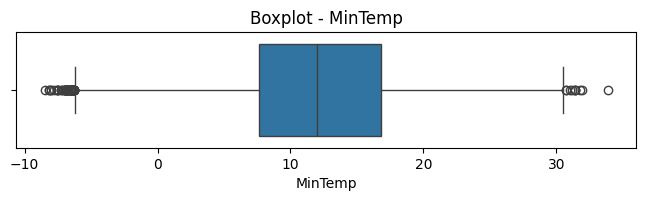

In [5]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["MinTemp"])
plt.title("Boxplot - MinTemp")
plt.show()


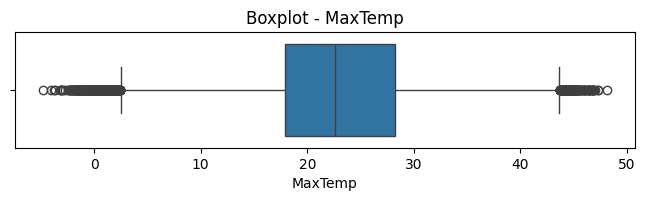

In [6]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["MaxTemp"])
plt.title("Boxplot - MaxTemp")
plt.show()


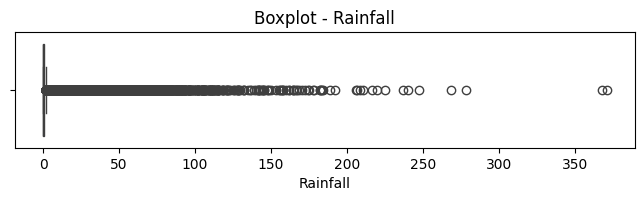

In [7]:
plt.figure(figsize=(8, 1.5))
sns.boxplot(x=df["Rainfall"])
plt.title("Boxplot - Rainfall")
plt.show()
